### `Introduction`

We propose to compute the Random forest (RF) model proposed by Ana Rita Ferreira for comparaison. Since the RF is also quite more popular than the LightGBM model, this approach can help one understand the work we've presented.

In [75]:
# Dependencies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import logging
import sys
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

### `The Random Forest for Rates previsions`


`The Model`

Random Forest is a powerful machine learning algorithm that is well-suited for the task of predicting changes in the effective Federal Funds Rate (EFFR). This problem involves high-dimensional data with potentially complex relationships between macroeconomic indicators and rate changes. Random Forest's ensemble approach, which combines multiple decision trees, makes it robust to noise and capable of capturing non-linear relationships between features. Additionally, it provides feature importance scores, helping to identify which variables have the most predictive power, which is crucial for understanding the drivers of monetary policy decisions. Its ability to handle imbalanced datasets and flexibility with hyperparameter tuning further make it an ideal choice for this classification problem. The algorithm operates by constructing multiple decision trees during training and aggregating their predictions. Each tree is trained on a bootstrapped sample of the data, with random feature selection at each split to introduce diversity. This approach reduces overfitting and improves generalization, especially in datasets like ours, where temporal and macroeconomic trends are key.

Foundational Algorithm: Random Forest

Random Forest is an ensemble learning algorithm that constructs multiple decision trees and combines their outputs to enhance prediction accuracy and generalization. For classification, it uses majority voting across the trees, while for regression, it averages the predictions. The core components are as follows:

- Bootstrap Aggregation (Bagging)

    From the original dataset $D$ , Random Forest generates multiple bootstrapped datasets $D_1, D_2,...,D_B$. Each bootstrapped dataset is a random sample drawn with replacement from $D$. This process ensures diversity among the trees.

- Random Feature Selection

    At each node of a decision tree, a random subset of features $m$ is selected from the total features $M$. This randomness reduces correlation between the trees, enhancing their ability to generalize to unseen data.

- Tree Predictions and Aggregation

    For a classification problem, the final prediction $\hat{y}$ is determined by majority voting:

    $\hat{y} = \text{mode}\left(\{h_1(x), h_2(x), \ldots, h_B(x)\}\right)$

    where $h_i(x)$ is the prediction of the $i$ -th tree. For regression, the prediction is the average of the tree outputs:

    $\hat{y} = \frac{1}{B} \sum_{i=1}^B h_i(x)$

    Random Forest's robustness arises from combining the predictions of diverse, independent trees, each trained on different subsets of the data and features.

- Feature Importance

    Random Forest provides a measure of feature importance based on the Gini impurity or entropy reduction achieved by each feature across all trees. This helps to identify which variables are most influential in predicting the target.




In [16]:
def create_lagged_features(df, target, features, lags):
    lagged_df = df.copy()
    for lag in range(1, lags + 1):
        for feature in features:
            lagged_df[f'{feature}_lag{lag}'] = df[feature].shift(lag)
    
    # Drop rows with NaN values caused by shifting
    lagged_df = lagged_df.dropna().reset_index(drop=True)
    
    # Define X and y
    X = lagged_df[[f'{feature}_lag{lag}' for feature in features for lag in range(1, lags + 1)]]
    y = lagged_df[target]
    
    return X, y, lagged_df

LightGBM Model RMSE: 0.7040970388444635

RF Model RMSE: 0.8391049033609943


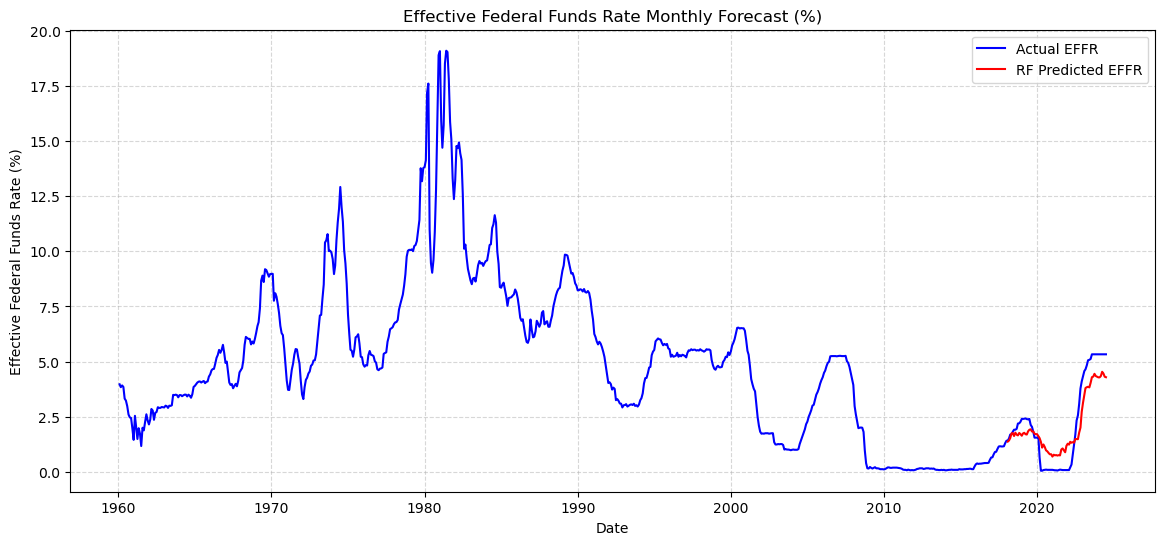

In [69]:
# Load the dataset
file_path = '/Users/walpoel/Desktop/FAC/ENSAE/ML for pf management and trading/data/current_no_NA.csv'
data = pd.read_csv(file_path)
data = data.iloc[1:]

# Convert the date column to datetime format
data['sasdate'] = pd.to_datetime(data['sasdate'], errors='coerce')

# Identify columns available before 1992
valid_columns = data.columns[data.notna().loc[data['sasdate'] < '1992-01-01'].all()]

# Filter data to use only these columns and all rows
filtered_data = data[valid_columns]

# Use all available columns except the target and date
features = [col for col in filtered_data.columns if col not in ['sasdate', 'FEDFUNDS']]
target = 'FEDFUNDS'

# Create lagged features
X, y, lagged_data = create_lagged_features(filtered_data, target, features, lags=10)

# Split the data chronologically
train_size = int(len(lagged_data) * 0.90)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=20, 
    max_depth=6, 
    min_samples_split=2, 
    min_samples_leaf=2, 
    max_features='sqrt', 
    random_state=42
)
rf_model.fit(X_train, y_train)

# Evaluate the model
rf_predictions = rf_model.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_predictions)
print(f"LightGBM Model RMSE: {rf_rmse}\n")
rf_logrmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f"RF Model RMSE: {rf_logrmse}")

# Plot predictions against actual values
lagged_data['Predicted_FEDFUNDS'] = np.nan
lagged_data.loc[X_test.index, 'Predicted_FEDFUNDS'] = rf_predictions

plt.figure(figsize=(14, 6))
plt.plot(lagged_data['sasdate'], lagged_data['FEDFUNDS'], label='Actual EFFR', color='blue')
plt.plot(lagged_data['sasdate'], lagged_data['Predicted_FEDFUNDS'], label='RF Predicted EFFR', color='red')
plt.title('Effective Federal Funds Rate Monthly Forecast (%)')
plt.xlabel('Date')
plt.ylabel('Effective Federal Funds Rate (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

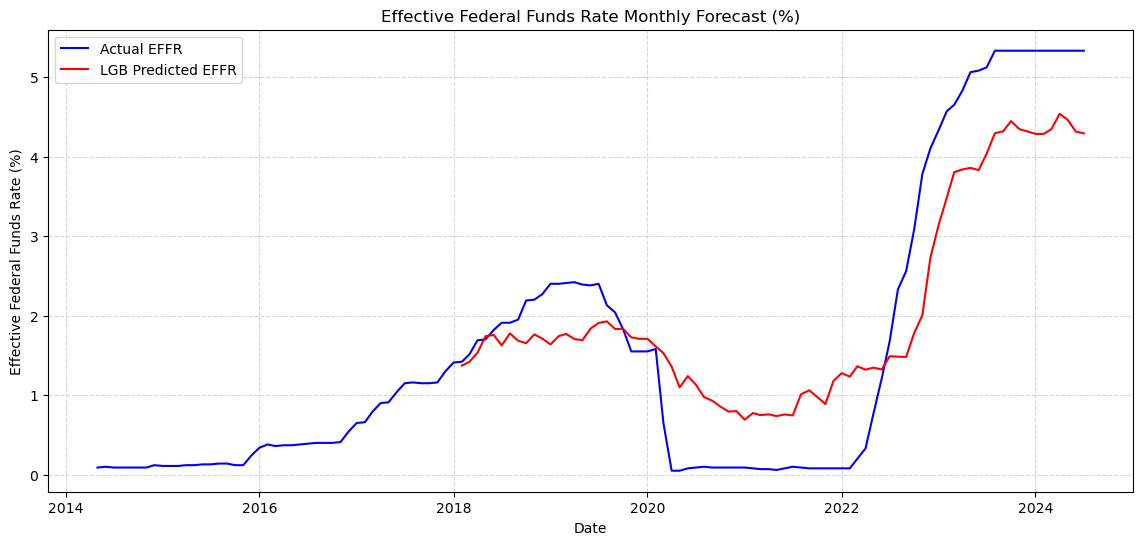

In [71]:
start_date = '2014-05-01'
# Filter the DataFrame to include only rows from the specified date onwards
filtered_data = lagged_data[lagged_data['sasdate'] >= start_date]
# Create the plot
plt.figure(figsize=(14, 6))
plt.plot(filtered_data['sasdate'], filtered_data['FEDFUNDS'], label='Actual EFFR', color='blue')
plt.plot(filtered_data['sasdate'], filtered_data['Predicted_FEDFUNDS'], label='LGB Predicted EFFR', color='red')
plt.title('Effective Federal Funds Rate Monthly Forecast (%)')
plt.xlabel('Date')
plt.ylabel('Effective Federal Funds Rate (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Without being much of a surprise, the RF model is less accurate than the LightGBM (as shown before the first graph with RMSE almost 8 times mhigher than the LGBM's RMSE). My main concern about this model is that it seems unable to grasp the broader market dynamics, as its predictions are consistently lower than the actual values during periods of rate hikes and consistently higher during periods of rate declines. The shape of the predicted rates could almost be seen as a moving average, making the use of a complex model like the random forest seem unnecessary.